In [11]:
%reload_ext autoreload
%autoreload 2

from pathlib import Path

from torchvision.transforms import v2, functional as F
import torch
from torch.utils.data import DataLoader
from torch.optim import Adam, RMSprop
from torchsummary import summary

from delicato.train_test_split import init_split, generate_train_examples
from delicato.dataset import BlobDataset
from delicato.model import Signet
from delicato.train import contrastiveLoss, fit, ContrastiveLoss

In [3]:
data_path = Path() / 'data' / 'blob' 

init_train_df, val_df, test_df = init_split(data_path, train_size=0.7, val_size=0.15, test_size=0.15, seed=77)

Train: 38 ratio: 0.6909090909090909
Val: 8 ratio: 0.14545454545454545
Test: 9 ratio: 0.16363636363636364


In [4]:
train_df = generate_train_examples(init_train_df)
val_df = generate_train_examples(val_df)

In [5]:
train_df.head()

,path_a,path_b,is_genuine,id
0,data\blob\cedar_1\genuine\original_1_1.png,data\blob\cedar_1\genuine\original_1_1.png,True,cedar_1
1,data\blob\cedar_1\genuine\original_1_1.png,data\blob\cedar_1\genuine\original_1_10.png,True,cedar_1
2,data\blob\cedar_1\genuine\original_1_1.png,data\blob\cedar_1\genuine\original_1_11.png,True,cedar_1
3,data\blob\cedar_1\genuine\original_1_1.png,data\blob\cedar_1\genuine\original_1_12.png,True,cedar_1
4,data\blob\cedar_1\genuine\original_1_1.png,data\blob\cedar_1\genuine\original_1_13.png,True,cedar_1


In [6]:
train_transforms = v2.Compose([
    v2.Grayscale(),
    v2.Resize((155, 220)),
    v2.RandomRotation(10),
    v2.PILToTensor(),
    v2.ToDtype(torch.float32, scale=True),
    F.invert,
    v2.Normalize((0.0907,), (0.1941,))
])

In [8]:
"""
from PIL import Image

means = []
stds = []


for i in range(len(init_train_df)):
    path = init_train_df.iloc[i]['path']
    img = Image.open(path)
    img = train_transforms(img)

    means.append(img.mean())
    stds.append(img.std())
    
print(sum(means) / len(means))
print(sum(stds) / len(stds))
"""

"\nfrom PIL import Image\n\nmeans = []\nstds = []\n\n\nfor i in range(len(init_train_df)):\n    path = init_train_df.iloc[i]['path']\n    img = Image.open(path)\n    img = train_transforms(img)\n\n    means.append(img.mean())\n    stds.append(img.std())\n    \nprint(sum(means) / len(means))\nprint(sum(stds) / len(stds))\n"

In [8]:
train_ds = BlobDataset(train_df, transforms=train_transforms)
val_ds = BlobDataset(val_df)

train_dl = DataLoader(train_ds, batch_size=16, shuffle=True, num_workers=8)
val_dl = DataLoader(val_ds, batch_size=16, shuffle=False, num_workers=4)
loaders = { 'train': train_dl, 'val': val_dl }

In [9]:
from delicato.model import Signet

model = Signet()
#summary(model, (1, 155, 220))

In [14]:
optimizer = Adam(model.parameters(), lr=0.001)
critertion = contrastiveLoss
critertion = ContrastiveLoss(alpha=1, beta=1, margin=1)
epochs = 10

fit(model, loaders, optimizer, critertion, epochs, device=torch.device('cuda'))

  0%|          | 0/2793 [00:00<?, ?it/s]

to device time: 0.0035119056701660156
zero grad time: 0.0
forward time: 0.003006458282470703
loss time: 0.0
backward time: 0.003998756408691406
to device time: 0.37455010414123535
zero grad time: 0.0
forward time: 0.0020003318786621094
loss time: 0.0
backward time: 0.0035076141357421875
to device time: 0.3036019802093506
zero grad time: 0.0
forward time: 0.002001047134399414
loss time: 0.0
backward time: 0.0035071372985839844
to device time: 0.3025548458099365
zero grad time: 0.0009996891021728516
forward time: 0.002000570297241211
loss time: 0.0
backward time: 0.002507448196411133
to device time: 0.305295467376709
zero grad time: 0.0
forward time: 0.002000093460083008
loss time: 0.0005040168762207031
backward time: 0.0020036697387695312
to device time: 0.3077392578125
zero grad time: 0.0
forward time: 0.002009868621826172
loss time: 0.0
backward time: 0.002003192901611328
to device time: 0.3048229217529297
zero grad time: 0.0009999275207519531
forward time: 0.002000093460083008
loss t

KeyboardInterrupt: 

In [77]:

inputs_a_1 = train_ds[0][0]
inputs_a_2 = train_ds[1][0]
inputs_b_1 = train_ds[0][1]
inputs_b_2 = train_ds[1][1]
inputs_a = torch.stack([inputs_a_1, inputs_a_2])
inputs_b = torch.stack([inputs_b_1, inputs_b_2])
#print(inputs_a.shape)

model(inputs_a, inputs_b).shape

torch.Size([2, 256, 1, 1])
torch.Size([2, 256])


torch.Size([2])

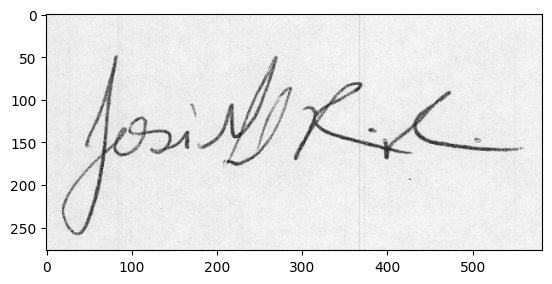

In [ ]:
# show image
import matplotlib.pyplot as plt
from PIL import Image

img = Image.open(train_df.iloc[0]['path_a'])

t1 = F.to_tensor(img)[0]
plt.imshow(t1, cmap='gray')

tensor(0.9288)


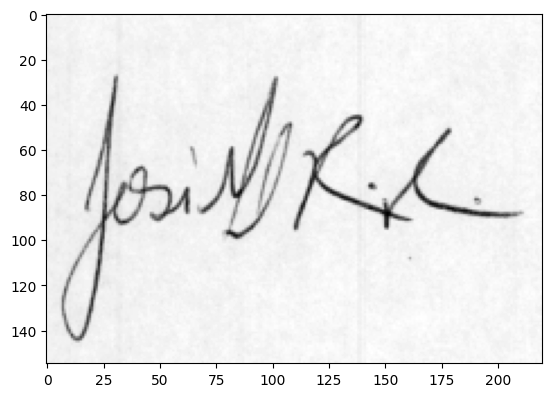

In [ ]:
t2 = F.to_grayscale(img)
t2 = F.resize(t2, (155, 220))
t2 = F.to_tensor(t2)[0]
print(t2.mean())
plt.imshow(t2, cmap='gray')

tensor(0.0712)


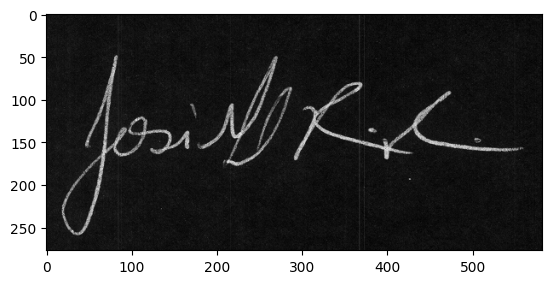

In [ ]:
t3 = F.to_grayscale(img)
t3 = F.to_tensor(t3)
t3 = F.invert(t3)[0]
print(t3.mean())
plt.imshow(t3, cmap='gray')

tensor(-0.1006)


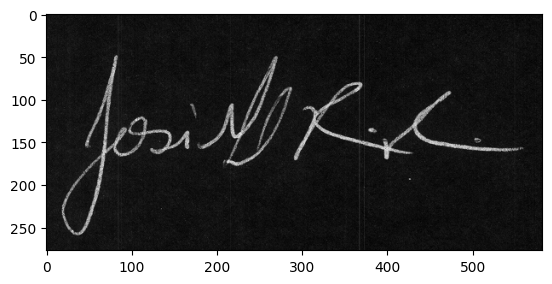

In [ ]:
t4 = F.to_grayscale(img)
t4 = F.invert(t4)
t4 = F.to_tensor(t4)
t4 = F.normalize(t4, (0.0907,), (0.1941,))[0]
print(t4.mean())
plt.imshow(t4, cmap='gray')

In [37]:
import torch
from torch import linalg as LA
a = torch.tensor([[1,1.], [1,1.]])
b = torch.tensor([[1,4.], [1,1.]])

torch.cdist(a, b), LA.vector_norm(a - b, dim=1)

(tensor([[3., 0.],
         [3., 0.]]),
 tensor([3., 0.]))

In [56]:
c = torch.tensor([1])

c.unsqueeze(0).shape


torch.Size([1, 1])

In [ ]:
# (16, 1, 155, 220)

